In [1]:
import pandas as pd
import talib.abstract as ta
import pandas_datareader as web
from technical import qtpylib

In [3]:
df = pd.read_json(path_or_buf="BTC_USDT_USDT-5m-futures.json")
df.columns = ["date", "open", "high", "low", "close", "volume"]

In [4]:
df

,date,open,high,low,close,volume
0,1642240800000,43042.65,43048.32,42984.08,43007.98,524.019
1,1642241100000,43007.99,43213.88,43006.00,43150.00,2209.402
2,1642241400000,43149.99,43189.84,43112.45,43184.39,824.115
3,1642241700000,43184.39,43279.93,43173.12,43196.00,1913.353
4,1642242000000,43196.01,43211.00,43103.31,43128.01,1130.486
...,...,...,...,...,...,...
147807,1686582900000,25819.10,25819.10,25780.80,25785.50,665.650
147808,1686583200000,25785.50,25813.00,25773.00,25812.70,1124.828
147809,1686583500000,25812.70,25812.80,25775.40,25793.60,1127.366
147810,1686583800000,25793.70,25824.10,25789.20,25818.00,646.481


In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.signal import find_peaks, peak_widths
from scipy.signal import argrelextrema
from technical import qtpylib

""" 
           .__.__                
      ____ |__|  |  __ _____  ___
     /    \|  |  | |  |  \  \/  /
    |   |  \  |  |_|  |  />    < 
    |___|  /__|____/____//__/\_ \
         \/                    \/

    Legendary TA Collection

    A collection of indicators ported from MT4 and Pine

     ✓ No lookahead, repainting or rewriting of candles
     ✓ Tested with Freqtrade and FreqAI
     ✓ More to come!


    Usage:

            # Fisher Stochastic Center of Gravity
            dataframe = lta.fisher_cg(dataframe)
            # dataframe["fisher_cg"]                    Float (Center Line)
            # dataframe["fisher_sig"]                   Float (Trigger Line)

            # Leledc Exhaustion Bars
            dataframe = lta.exhaustion_bars(dataframe)
            # dataframe["leledc_major"]                  = 1 (Up) / -1 (Down) Direction
            # dataframe["leledc_minor"]                  = 1 Sellers exhausted / 0 Hold / -1 Buyers exhausted 

            # Stochastic Momentum Index
            dataframe = lta.smi_momentum(dataframe)
            # dataframe["smi"]                          Float (SMI)

            # Pinbar Reversals
            dataframe = lta.pinbar(dataframe, dataframe["smi"])
            # dataframe["pinbar_buy"]                   Bool
            # dataframe["pinbar_sell"]                  Bool

            # Breakouts and Retests
            dataframe = lta.breakouts(dataframe)
            # dataframe['support_level']                Float (Support)
            # dataframe['resistance_level']             Float (Resistance)
            # dataframe['support_breakout']             Bool
            # dataframe['resistance_breakout']          Bool
            # dataframe['support_retest']               Bool
            # dataframe['potential_support_retest']     Bool
            # dataframe['resistance_retest']            Bool
            # dataframe['potential_resistance_retest']  Bool

"""


def fisher_cg(df: DataFrame, length=20, min_period=10):
    """
    Fisher Stochastic Center of Gravity

    Original Pinescript by dasanc
    https://tradingview.com/script/5BT3a9mJ-Fisher-Stochastic-Center-of-Gravity/

    :return: DataFrame with fisher_cg and fisher_sig column populated
    """

    df['hl2'] = (df['high'] + df['low']) / 2

    if length < min_period:
        length = min_period

    num = 0.0
    denom = 0.0
    CG = 0.0
    MaxCG = 0.0
    MinCG = 0.0
    Value1 = 0.0
    Value2 = 0.0
    Value3 = 0.0

    for i in range(length):
        num += (1 + i) * df['hl2'].shift(i)
        denom += df['hl2'].shift(i)

    CG = -num / denom + (length + 1) / 2
    MaxCG = CG.rolling(window=length).max()
    MinCG = CG.rolling(window=length).min()

    Value1 = np.where(MaxCG != MinCG, (CG - MinCG) / (MaxCG - MinCG), 0)
    Value2 = (4 * Value1 + 3 * np.roll(Value1, 1) + 2 * np.roll(Value1, 2) + np.roll(Value1,
                                                                                     3)) / 10
    Value3 = 0.5 * np.log((1 + 1.98 * (Value2 - 0.5)) / (1 - 1.98 * (Value2 - 0.5)))

    df['fisher_cg'] = pd.Series(Value3)  # Center of Gravity
    df['fisher_sig'] = pd.Series(Value3).shift(1)  # Signal / Trigger

    return df


def breakouts(df: DataFrame, length=20):
    """
    S/R Breakouts and Retests

    Makes it easy to work with Support and Resistance
    Find Retests, Breakouts and the next levels

    :return: DataFrame with event columns populated
    """

    high = df['high']
    low = df['low']
    close = df['close']

    pl = low.rolling(window=length * 2 + 1).min()
    ph = high.rolling(window=length * 2 + 1).max()

    s_yLoc = low.shift(length + 1).where(low.shift(length + 1) > low.shift(length - 1),
                                         low.shift(length - 1))
    r_yLoc = high.shift(length + 1).where(high.shift(length + 1) > high.shift(length - 1),
                                          high.shift(length + 1))

    cu = close < s_yLoc.shift(length)
    co = close > r_yLoc.shift(length)

    s1 = (high >= s_yLoc.shift(length)) & (close <= pl.shift(length))
    s2 = (high >= s_yLoc.shift(length)) & (close >= pl.shift(length)) & (
                close <= s_yLoc.shift(length))
    s3 = (high >= pl.shift(length)) & (high <= s_yLoc.shift(length))
    s4 = (high >= pl.shift(length)) & (high <= s_yLoc.shift(length)) & (close < pl.shift(length))

    r1 = (low <= r_yLoc.shift(length)) & (close >= ph.shift(length))
    r2 = (low <= r_yLoc.shift(length)) & (close <= ph.shift(length)) & (
                close >= r_yLoc.shift(length))
    r3 = (low <= ph.shift(length)) & (low >= r_yLoc.shift(length))
    r4 = (low <= ph.shift(length)) & (low >= r_yLoc.shift(length)) & (close > ph.shift(length))

    # Events
    df['support_level'] = pl.diff().where(pl.diff().notna())
    df['resistance_level'] = ph.diff().where(ph.diff().notna())

    # Use the last S/R levels instead of nan
    df['support_level'] = df['support_level'].combine_first(df['support_level'].shift())
    df['resistance_level'] = df['resistance_level'].combine_first(df['resistance_level'].shift())

    df['support_breakout'] = cu
    df['resistance_breakout'] = co
    df['support_retest'] = s1 | s2 | s3 | s4
    df['potential_support_retest'] = s1 | s2 | s3
    df['resistance_retest'] = r1 | r2 | r3 | r4
    df['potential_resistance_retest'] = r1 | r2 | r3

    return df


def pinbar(df: DataFrame, smi=None):
    """
    Pinbar - Price Action Indicator

    Pinbars are an easy but sure indication
    of incoming price reversal.
    Signal confirmation with SMI.

    Pinescript Source by PeterO - Thx!
    https://tradingview.com/script/aSJnbGnI-PivotPoints-with-Momentum-confirmation-by-PeterO/

    :return: DataFrame with buy / sell signals columns populated
    """

    low = df['low']
    high = df['high']
    close = df['close']

    tr = true_range(df)

    if smi is None:
        df = smi_momentum(df)
        smi = df['smi']

    df['pinbar_sell'] = (
            (high < high.shift(1)) &
            (close < high - (tr * 2 / 3)) &
            (smi < smi.shift(1)) &
            (smi.shift(1) > 40) &
            (smi.shift(1) < smi.shift(2))
    )

    df['pinbar_buy'] = (
            (low > low.shift(1)) &
            (close > low + (tr * 2 / 3)) &
            (smi.shift(1) < -40) &
            (smi > smi.shift(1)) &
            (smi.shift(1) > smi.shift(2))
    )

    return df


def smi_momentum(df: DataFrame, k_length=9, d_length=3):
    """
    The Stochastic Momentum Index (SMI) Indicator was developed by
    William Blau in 1993 and is considered to be a momentum indicator
    that can help identify trend reversal points

    :return: DataFrame with smi column populated
    """

    ll = df['low'].rolling(window=k_length).min()
    hh = df['high'].rolling(window=k_length).max()

    diff = hh - ll
    rdiff = df['close'] - (hh + ll) / 2

    avgrel = rdiff.ewm(span=d_length).mean().ewm(span=d_length).mean()
    avgdiff = diff.ewm(span=d_length).mean().ewm(span=d_length).mean()

    df['smi'] = np.where(avgdiff != 0, (avgrel / (avgdiff / 2) * 100), 0)

    return df


def exhaustion_bars(dataframe, maj_qual=6, maj_len=12, min_qual=6, min_len=12, core_length=4):
    """
    Leledc Exhaustion Bars - Extended
    Infamous S/R Reversal Indicator

    leledc_major (Trend):
     1 Up
    -1 Down

    leledc_minor:
    1 Sellers exhausted
    0 Neutral / Hold
    -1 Buyers exhausted

    Original (MT4) https://www.abundancetradinggroup.com/leledc-exhaustion-bar-mt4-indicator/

    :return: DataFrame with columns populated
    """

    bindex_maj, sindex_maj, trend_maj = 0, 0, 0
    bindex_min, sindex_min = 0, 0

    for i in range(len(dataframe)):
        close = dataframe['close'][i]

        if i < 1 or i - core_length < 0:
            dataframe.loc[i, 'leledc_major'] = np.nan
            dataframe.loc[i, 'leledc_minor'] = 0
            continue

        bindex_maj, sindex_maj = np.nan_to_num(bindex_maj), np.nan_to_num(sindex_maj)
        bindex_min, sindex_min = np.nan_to_num(bindex_min), np.nan_to_num(sindex_min)

        if close > dataframe['close'][i - core_length]:
            bindex_maj += 1
            bindex_min += 1
        elif close < dataframe['close'][i - core_length]:
            sindex_maj += 1
            sindex_min += 1

        update_major = False
        if bindex_maj > maj_qual and close < dataframe['open'][i] and dataframe['high'][i] >= \
                dataframe['high'][i - maj_len:i].max():
            bindex_maj, trend_maj, update_major = 0, 1, True
        elif sindex_maj > maj_qual and close > dataframe['open'][i] and dataframe['low'][i] <= \
                dataframe['low'][i - maj_len:i].min():
            sindex_maj, trend_maj, update_major = 0, -1, True

        dataframe.loc[
            i, 'leledc_major'] = trend_maj if update_major else np.nan if trend_maj == 0 else trend_maj

        if bindex_min > min_qual and close < dataframe['open'][i] and dataframe['high'][i] >= \
                dataframe['high'][i - min_len:i].max():
            bindex_min = 0
            dataframe.loc[i, 'leledc_minor'] = -1
        elif sindex_min > min_qual and close > dataframe['open'][i] and dataframe['low'][i] <= \
                dataframe['low'][i - min_len:i].min():
            sindex_min = 0
            dataframe.loc[i, 'leledc_minor'] = 1
        else:
            dataframe.loc[i, 'leledc_minor'] = 0

    return dataframe


"""
Dynamic Leledc Exhaustion Bars
"""


def dynamic_exhaustion_bars(dataframe, window=500):
    """
    Dynamic Leledc Exhaustion Bars -  By nilux
    The lookback length and exhaustion bars adjust dynamically to the market.

    leledc_major (Trend):
     1 Up
    -1 Down

    leledc_minor:
    1 Sellers exhausted
    0 Neutral / Hold
    -1 Buyers exhausted

    :return: DataFrame with columns populated
    """

    dataframe['close_pct_change'] = dataframe['close'].pct_change()
    dataframe['pct_change_zscore'] = qtpylib.zscore(dataframe, col='close_pct_change')
    dataframe['pct_change_zscore_smoothed'] = dataframe['pct_change_zscore'].rolling(
        window=3).mean()
    dataframe['pct_change_zscore_smoothed'].fillna(1.0, inplace=True)

    # To Do: Improve outlier detection

    zscore = dataframe['pct_change_zscore_smoothed'].to_numpy()
    zscore_multi = np.maximum(np.minimum(5.0 - zscore * 2, 5.0), 1.5)

    maj_qual, min_qual = calculate_exhaustion_candles(dataframe, window, zscore_multi)

    dataframe['maj_qual'] = maj_qual
    dataframe['min_qual'] = min_qual

    maj_len, min_len = calculate_exhaustion_lengths(dataframe)

    dataframe['maj_len'] = maj_len
    dataframe['min_len'] = min_len

    dataframe = populate_leledc_major_minor(dataframe, maj_qual, min_qual, maj_len, min_len)

    return dataframe


def populate_leledc_major_minor(dataframe, maj_qual, min_qual, maj_len, min_len):
    bindex_maj, sindex_maj, trend_maj = 0, 0, 0
    bindex_min, sindex_min = 0, 0

    dataframe['leledc_major'] = np.nan
    dataframe['leledc_minor'] = 0

    for i in range(1, len(dataframe)):
        close = dataframe['close'][i]
        short_length = i if i < 4 else 4

        if close > dataframe['close'][i - short_length]:
            bindex_maj += 1
            bindex_min += 1
        elif close < dataframe['close'][i - short_length]:
            sindex_maj += 1
            sindex_min += 1

        update_major = False
        if bindex_maj > maj_qual[i] and close < dataframe['open'][i] and dataframe['high'][i] >= \
                dataframe['high'][i - maj_len:i].max():
            bindex_maj, trend_maj, update_major = 0, 1, True
        elif sindex_maj > maj_qual[i] and close > dataframe['open'][i] and dataframe['low'][i] <= \
                dataframe['low'][i - maj_len:i].min():
            sindex_maj, trend_maj, update_major = 0, -1, True

        dataframe.at[
            i, 'leledc_major'] = trend_maj if update_major else np.nan if trend_maj == 0 else trend_maj
        if bindex_min > min_qual[i] and close < dataframe['open'][i] and dataframe['high'][i] >= \
                dataframe['high'][i - min_len:i].max():
            bindex_min = 0
            dataframe.at[i, 'leledc_minor'] = -1
        elif sindex_min > min_qual[i] and close > dataframe['open'][i] and dataframe['low'][i] <= \
                dataframe['low'][i - min_len:i].min():
            sindex_min = 0
            dataframe.at[i, 'leledc_minor'] = 1
        else:
            dataframe.at[i, 'leledc_minor'] = 0

    return dataframe


def calculate_exhaustion_candles(dataframe, window, multiplier):
    """
    Calculate the average consecutive length of ups and downs to adjust the exhaustion bands dynamically
    To Do: Apply ML (FreqAI) to make prediction
    """
    consecutive_diff = np.sign(dataframe['close'].diff())
    maj_qual = np.zeros(len(dataframe))
    min_qual = np.zeros(len(dataframe))

    for i in range(len(dataframe)):
        idx_range = consecutive_diff[i - window + 1:i + 1] if i >= window else consecutive_diff[
                                                                               :i + 1]
        avg_consecutive = consecutive_count(idx_range)
        if isinstance(avg_consecutive, np.ndarray):
            avg_consecutive = avg_consecutive.item()
        maj_qual[i] = int(avg_consecutive * (3 * multiplier[i])) if not np.isnan(
            avg_consecutive) else 0
        min_qual[i] = int(avg_consecutive * (3 * multiplier[i])) if not np.isnan(
            avg_consecutive) else 0

    return maj_qual, min_qual


def calculate_exhaustion_lengths(dataframe):
    """
    Calculate the average length of peaks and valleys to adjust the exhaustion bands dynamically
    To Do: Apply ML (FreqAI) to make prediction
    """
    high_indices = argrelextrema(dataframe['high'].to_numpy(), np.greater)
    low_indices = argrelextrema(dataframe['low'].to_numpy(), np.less)

    avg_peak_distance = np.mean(np.diff(high_indices))
    std_peak_distance = np.std(np.diff(high_indices))
    avg_valley_distance = np.mean(np.diff(low_indices))
    std_valley_distance = np.std(np.diff(low_indices))

    maj_len = int(avg_peak_distance + std_peak_distance)
    min_len = int(avg_valley_distance + std_valley_distance)

    return maj_len, min_len

def hurst_exponent(dataframe, lookback=30):
    """
    Hurst Exponent
    The Hurst exponent is used as a measure of long-term memory of time series.
    It relates to the autocorrelations of the time series and the rate at which
    these decrease as the lag between pairs of values increases.

    When Hurst > 0.5, the market is trending and the volatility is high.
    When HE < 0.5, the market is mean reverting, and the volatility is low.
    """

    y = dataframe['close']
    ymin = y.rolling(window=lookback).min()
    ymax = y.rolling(window=lookback).max()
    yscl = ymax - ymin

    lngth = pd.Series(np.zeros(len(y)), index=y.index)
    N = lookback
    dx2 = 1.0 / (N * N)

    for i in range(1, len(y) - N + 1):
        if N < 2 or ymax[i] == ymin[i]:
            lngth[i + N - 1] = 1.0
        else:
            temp_lngth = 0.0
            for j in range(1, N + 1):
                dy = (y[i + j - 1] - y[i + j - 2]) / (yscl[i] if yscl[i] != 0 else 1)
                temp_lngth += np.sqrt(dx2 + (dy * dy))
            lngth[i + N - 1] = temp_lngth

    LOG2 = np.log(2.0)
    FDI = 1.0 + (np.log(np.where(lngth != 0, lngth, 1)) + LOG2) / np.log(2.0 * N)
    dataframe['hurst'] = 2.0 - FDI

    return dataframe['hurst']


def detect_pullback(df: DataFrame, periods=30, method='pct_outlier'):
    """
    Pullback & Outlier Detection
    Know when a sudden move and possible reversal is coming

    Method 1: StDev Outlier (z-score)
    Method 2: Percent-Change Outlier (z-score)
    Method 3: Candle Open-Close %-Change

    outlier_threshold - Recommended: 2.0 - 3.0

    df['pullback_flag']: 1 (Outlier Up) / -1 (Outlier Down)
    """
    if method == 'stdev_outlier':
        outlier_threshold = 2.0
        df['dif'] = df['close'] - df['close'].shift(1)
        df['dif_squared_sum'] = (df['dif'] ** 2).rolling(window=periods + 1).sum()
        df['std'] = np.sqrt((df['dif_squared_sum'] - df['dif'].shift(0) ** 2) / (periods - 1))
        df['z'] = df['dif'] / df['std']
        df['pullback_flag'] = np.where(df['z'] >= outlier_threshold, 1, 0)
        df['pullback_flag'] = np.where(df['z'] <= -outlier_threshold, -1, df['pullback_flag'])

    if method == 'pct_outlier':
        outlier_threshold = 2.0
        df["pb_pct_change"] = df["close"].pct_change()
        df['pb_zscore'] = qtpylib.zscore(df, window=periods, col='pb_pct_change')
        df['pullback_flag'] = np.where(df['pb_zscore'] >= outlier_threshold, 1, 0)
        df['pullback_flag'] = np.where(df['pb_zscore'] <= -outlier_threshold, -1,
                                       df['pullback_flag'])

    if method == 'candle_body':
        pullback_pct = 1.0
        df['change'] = df['close'] - df['open']
        df['pullback'] = (df['change'] / df['open']) * 100
        df['pullback_flag'] = np.where(df['pullback'] >= pullback_pct, 1, 0)
        df['pullback_flag'] = np.where(df['pullback'] <= -pullback_pct, -1, df['pullback_flag'])

    return df['pullback_flag']

"""
Misc. Helper Functions
"""


def linear_growth(start: float, end: float, start_time: int, end_time: int,
                  trade_time: int) -> float:
    """
    Simple linear growth function. Grows from start to end after end_time minutes (starts after start_time minutes)
    """
    time = max(0, trade_time - start_time)
    rate = (end - start) / (end_time - start_time)

    return min(end, start + (rate * time))


def linear_decay(start: float, end: float, start_time: int, end_time: int,
                 trade_time: int) -> float:
    """
    Simple linear decay function. Decays from start to end after end_time minutes (starts after start_time minutes)
    """
    time = max(0, trade_time - start_time)
    rate = (start - end) / (end_time - start_time)

    return max(end, start - (rate * time))


def true_range(dataframe):
    prev_close = dataframe['close'].shift()
    tr = pd.concat([dataframe['high'] - dataframe['low'], abs(dataframe['high'] - prev_close),
                    abs(dataframe['low'] - prev_close)], axis=1).max(axis=1)
    return tr


def consecutive_count(consecutive_diff):
    return np.mean(np.abs(np.diff(np.where(consecutive_diff != 0))))


def compare(a, b):
    return a > b


def compare_less(a, b):
    return a < b

In [28]:
data = smi_momentum(df, k_length=9, d_length=4)
data

,date,open,high,low,close,volume,smi
0,1642240800000,43042.65,43048.32,42984.08,43007.98,524.019,NaN
1,1642241100000,43007.99,43213.88,43006.00,43150.00,2209.402,NaN
2,1642241400000,43149.99,43189.84,43112.45,43184.39,824.115,NaN
3,1642241700000,43184.39,43279.93,43173.12,43196.00,1913.353,NaN
4,1642242000000,43196.01,43211.00,43103.31,43128.01,1130.486,NaN
...,...,...,...,...,...,...,...
147807,1686582900000,25819.10,25819.10,25780.80,25785.50,665.650,21.134503
147808,1686583200000,25785.50,25813.00,25773.00,25812.70,1124.828,25.831634
147809,1686583500000,25812.70,25812.80,25775.40,25793.60,1127.366,26.209609
147810,1686583800000,25793.70,25824.10,25789.20,25818.00,646.481,31.845669


<AxesSubplot: >

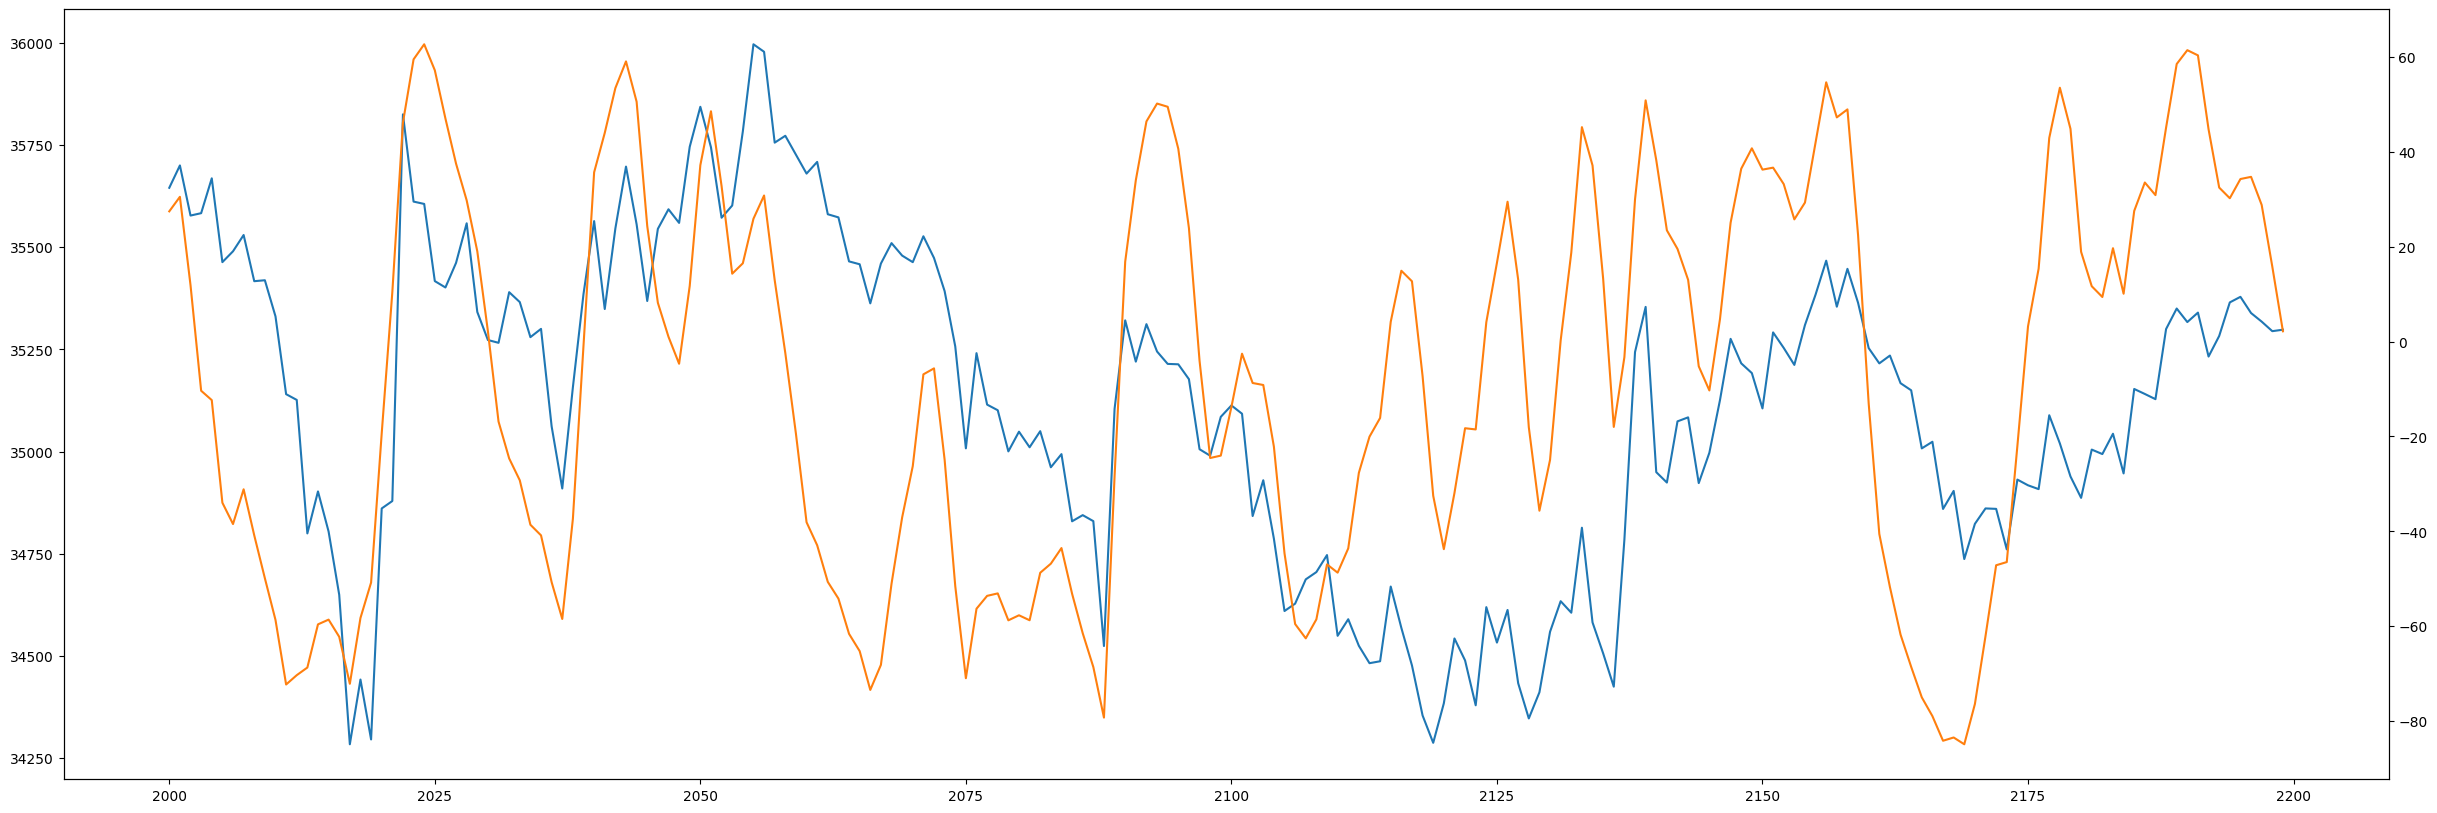

In [21]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["smi"][2000:2200]).plot(secondary_y=True)

<AxesSubplot: >

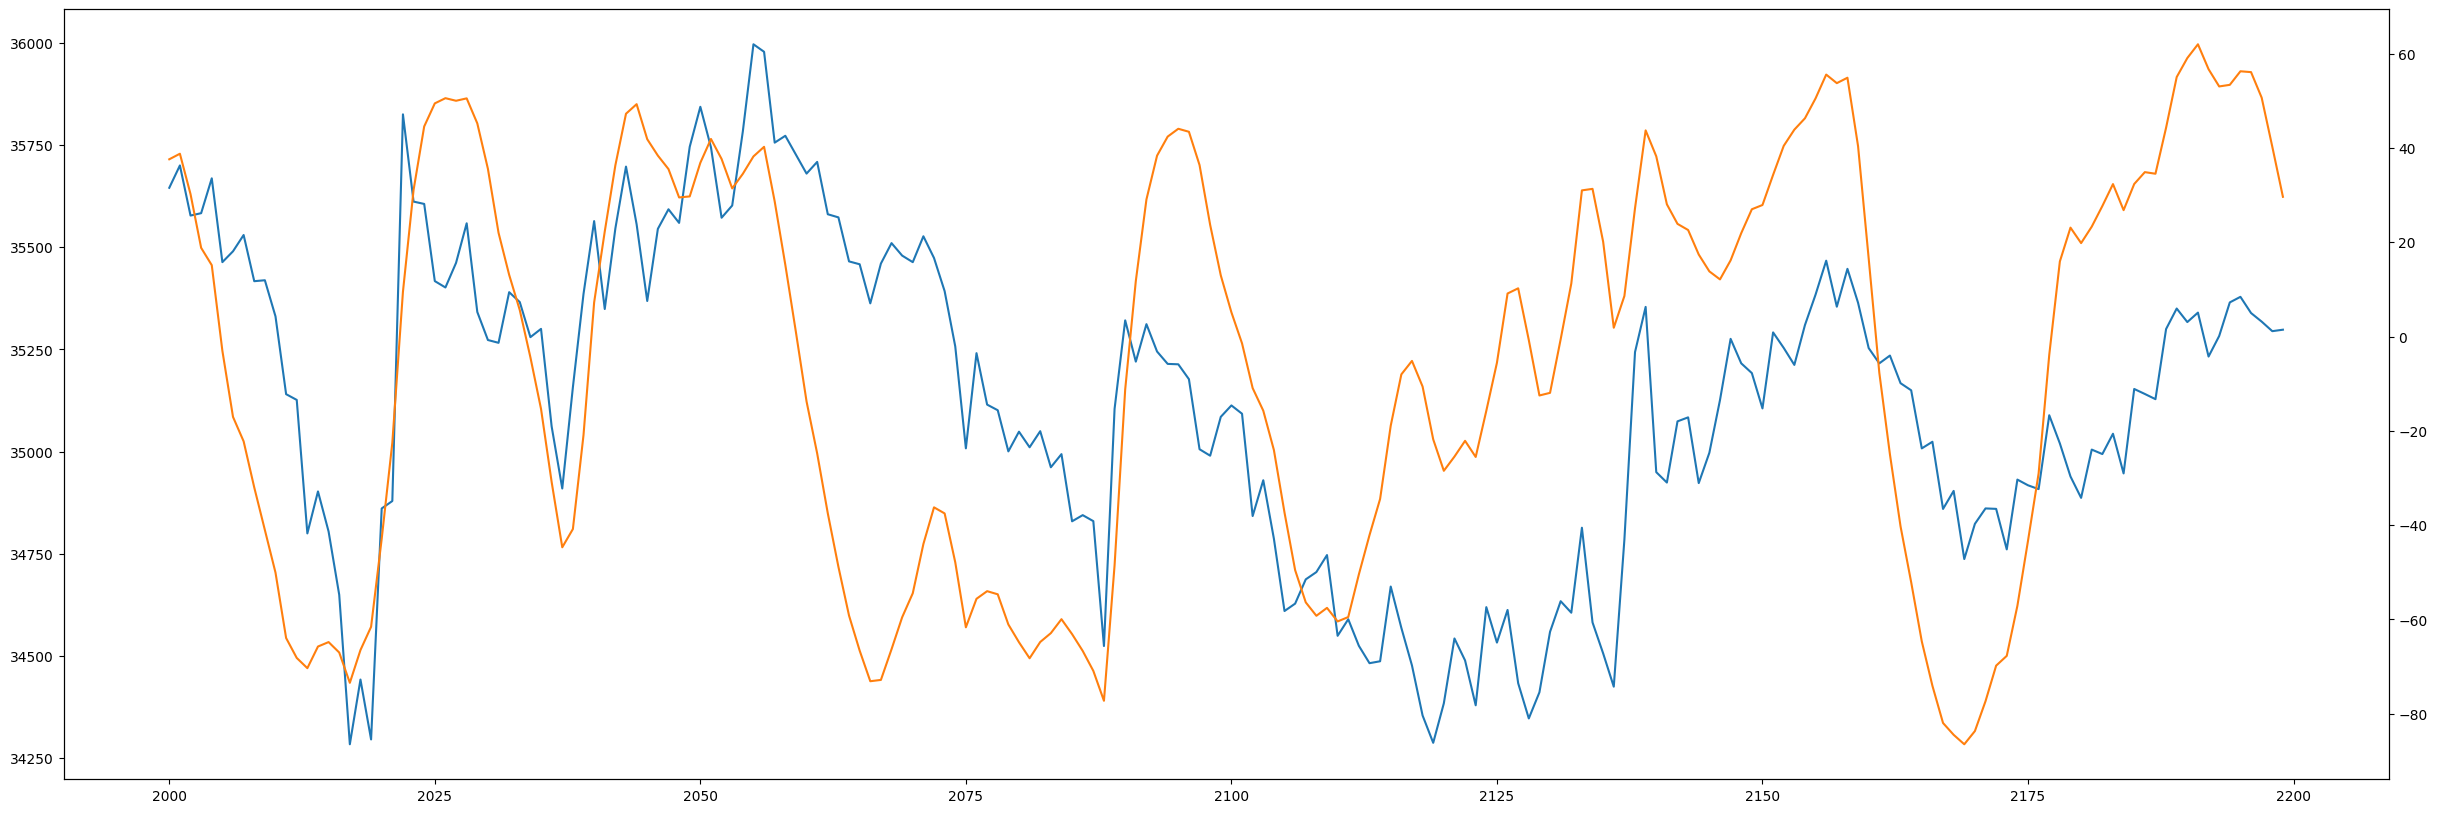

In [29]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["smi"][2000:2200]).plot(secondary_y=True)

<AxesSubplot: >

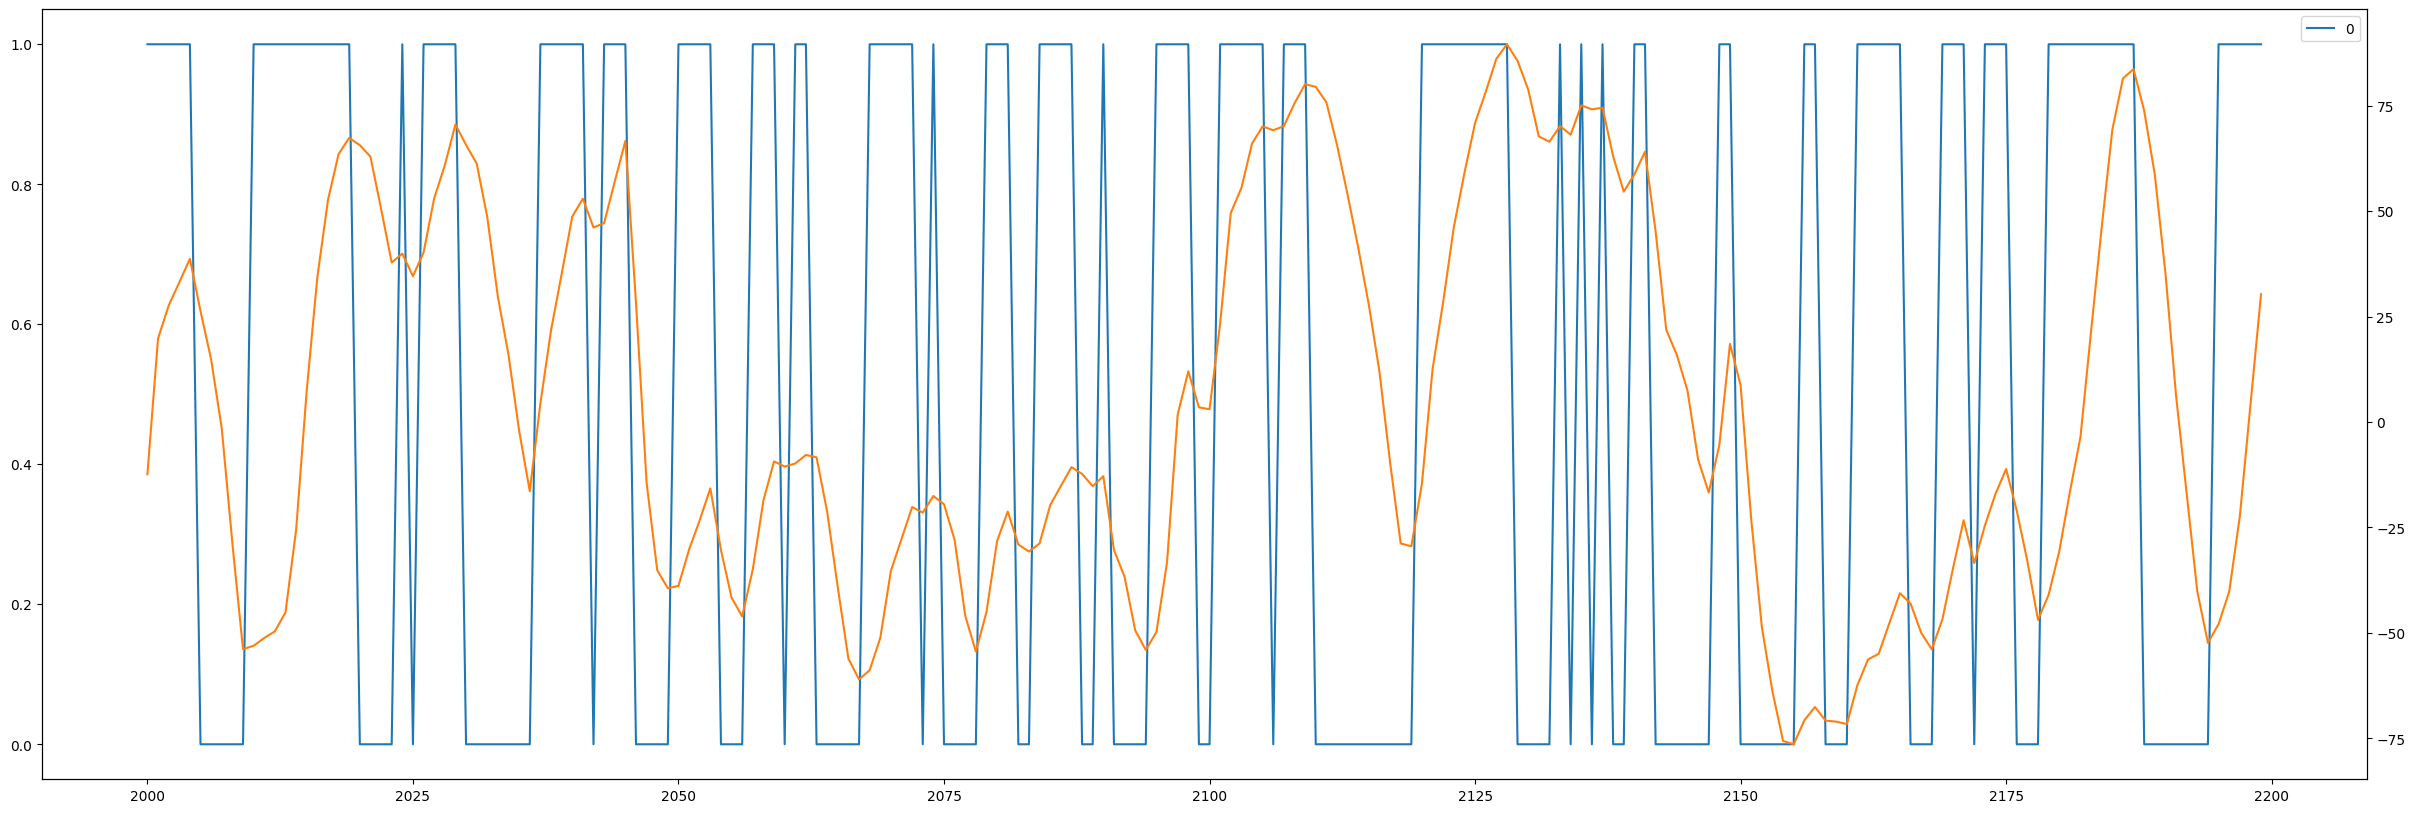

In [77]:
pd.DataFrame(np.where(data["smi"] > data["smi"].shift(1), 1, 0))[2000:2200].plot(figsize=(30, 10))
(data["smi"][2000:2200]).plot(secondary_y=True)

In [49]:
data = fisher_cg(data)
data

,date,open,high,low,close,adj_close,volume,smi,hl2,fisher_cg,fisher_sig
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600,NaN,0.128627,NaN,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800,NaN,0.121931,NaN,NaN
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000,NaN,0.113002,NaN,NaN
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600,NaN,0.115792,NaN,NaN
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600,NaN,0.119141,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10708,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,58.317374,181.494995,-0.314425,-0.578232
10709,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,44.412485,178.774994,-0.062151,-0.314425
10710,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,27.863297,179.265007,0.176785,-0.062151
10711,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,23.493459,179.150002,0.407077,0.176785


<AxesSubplot: >

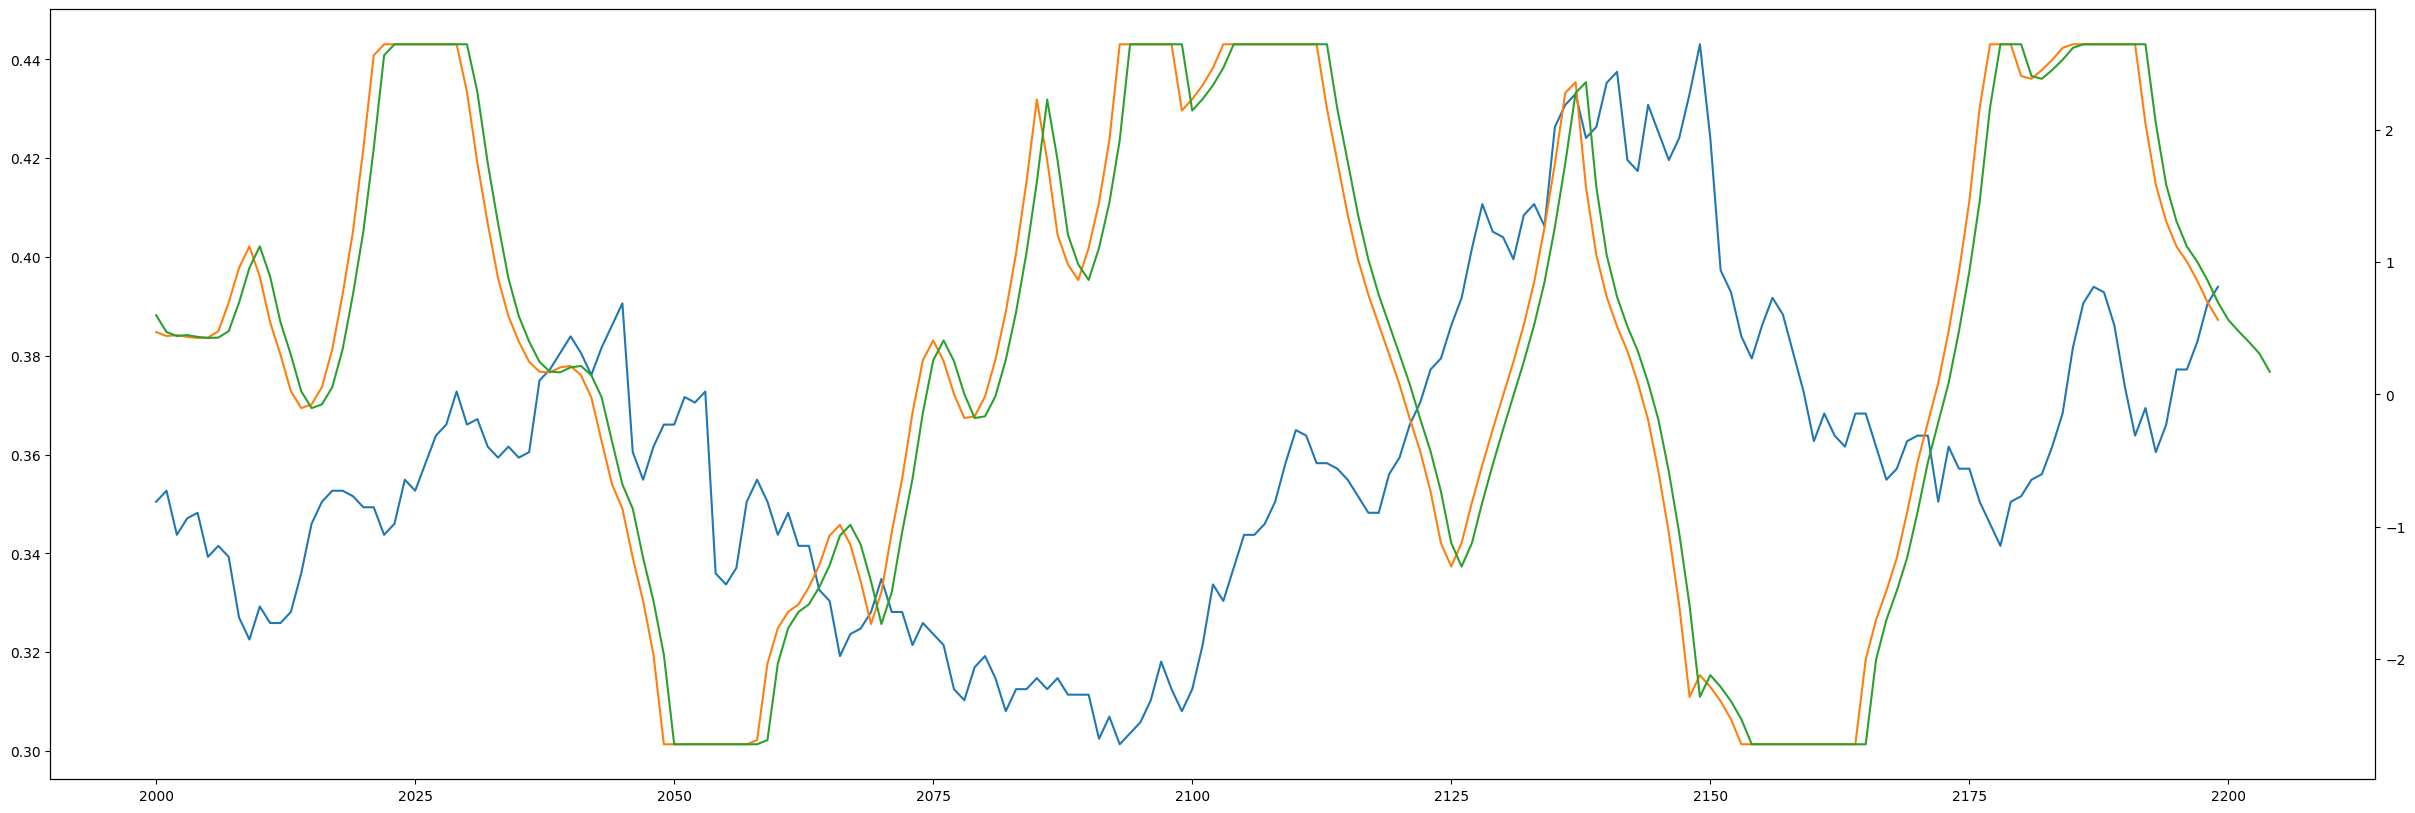

In [70]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["fisher_cg"][2000:2200]).plot(secondary_y=True)
(data["fisher_sig"][2000:2205]).plot(secondary_y=True)

In [53]:
data["%-hurst"] = hurst_exponent(data)
data

,date,open,high,low,close,adj_close,volume,smi,hl2,fisher_cg,fisher_sig,hurst,%-hurst
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600,NaN,0.128627,NaN,NaN,0.830706,0.830706
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800,NaN,0.121931,NaN,NaN,0.830706,0.830706
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000,NaN,0.113002,NaN,NaN,0.830706,0.830706
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600,NaN,0.115792,NaN,NaN,0.830706,0.830706
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600,NaN,0.119141,NaN,NaN,0.830706,0.830706
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,58.317374,181.494995,-0.314425,-0.578232,0.573979,0.573979
10709,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,44.412485,178.774994,-0.062151,-0.314425,0.547303,0.547303
10710,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,27.863297,179.265007,0.176785,-0.062151,0.542598,0.542598
10711,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,23.493459,179.150002,0.407077,0.176785,0.512509,0.512509


<AxesSubplot: >

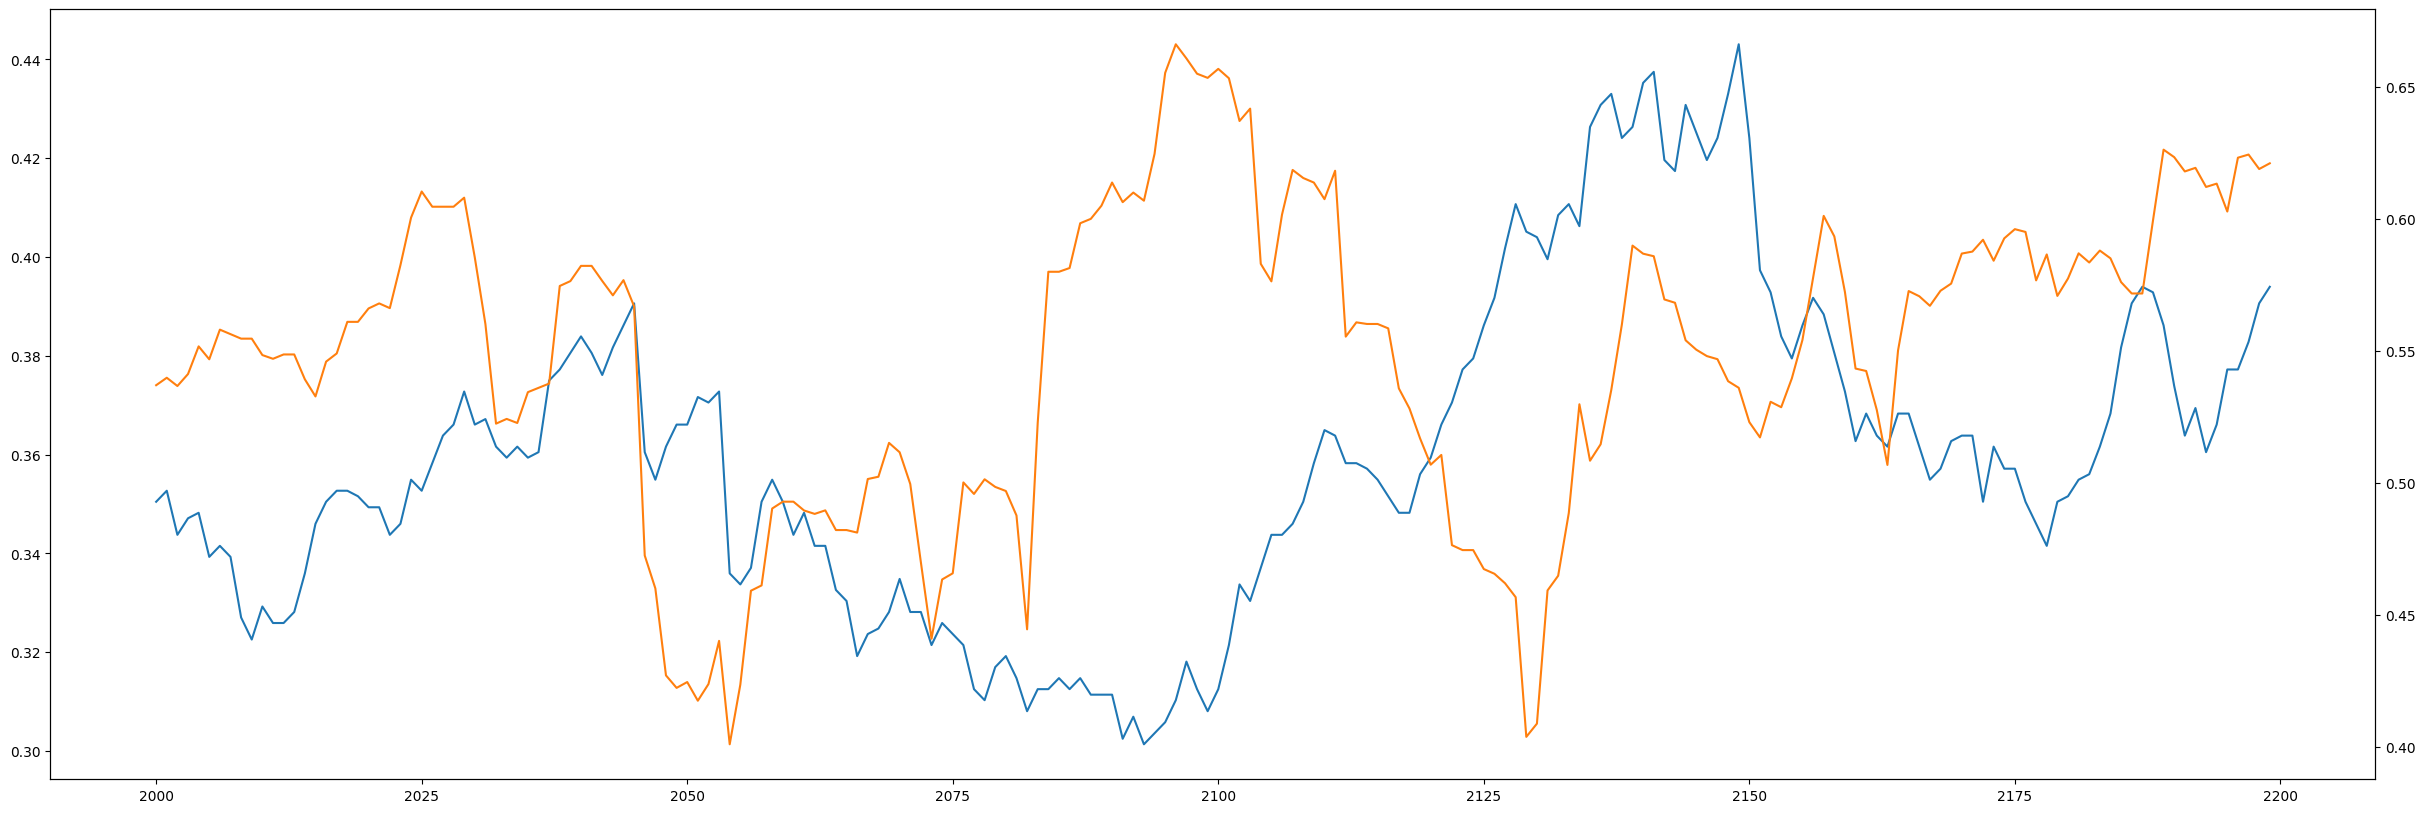

In [54]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["%-hurst"][2000:2200]).plot(secondary_y=True)

In [61]:
pinbar(data)

,date,open,high,low,close,adj_close,volume,smi,hl2,fisher_cg,...,pct_change_zscore,pct_change_zscore_smoothed,maj_qual,min_qual,maj_len,min_len,leledc_major,leledc_minor,pinbar_sell,pinbar_buy
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600,NaN,0.128627,NaN,...,NaN,1.000000,0.0,0.0,7,7,NaN,0,False,False
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800,NaN,0.121931,NaN,...,NaN,1.000000,9.0,9.0,7,7,NaN,0,False,False
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000,NaN,0.113002,NaN,...,NaN,1.000000,9.0,9.0,7,7,NaN,0,False,False
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600,NaN,0.115792,NaN,...,NaN,1.000000,9.0,9.0,7,7,NaN,0,False,False
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600,NaN,0.119141,NaN,...,NaN,1.000000,9.0,9.0,7,7,NaN,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,58.317374,181.494995,-0.314425,...,-1.100109,-0.050580,15.0,15.0,7,7,1.0,0,False,False
10709,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,44.412485,178.774994,-0.062151,...,-0.437478,-0.504446,15.0,15.0,7,7,1.0,0,False,False
10710,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,27.863297,179.265007,0.176785,...,-1.140967,-0.892851,15.0,15.0,7,7,1.0,0,False,False
10711,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,23.493459,179.150002,0.407077,...,1.547542,-0.010301,15.0,15.0,7,7,1.0,0,False,False


<AxesSubplot: >

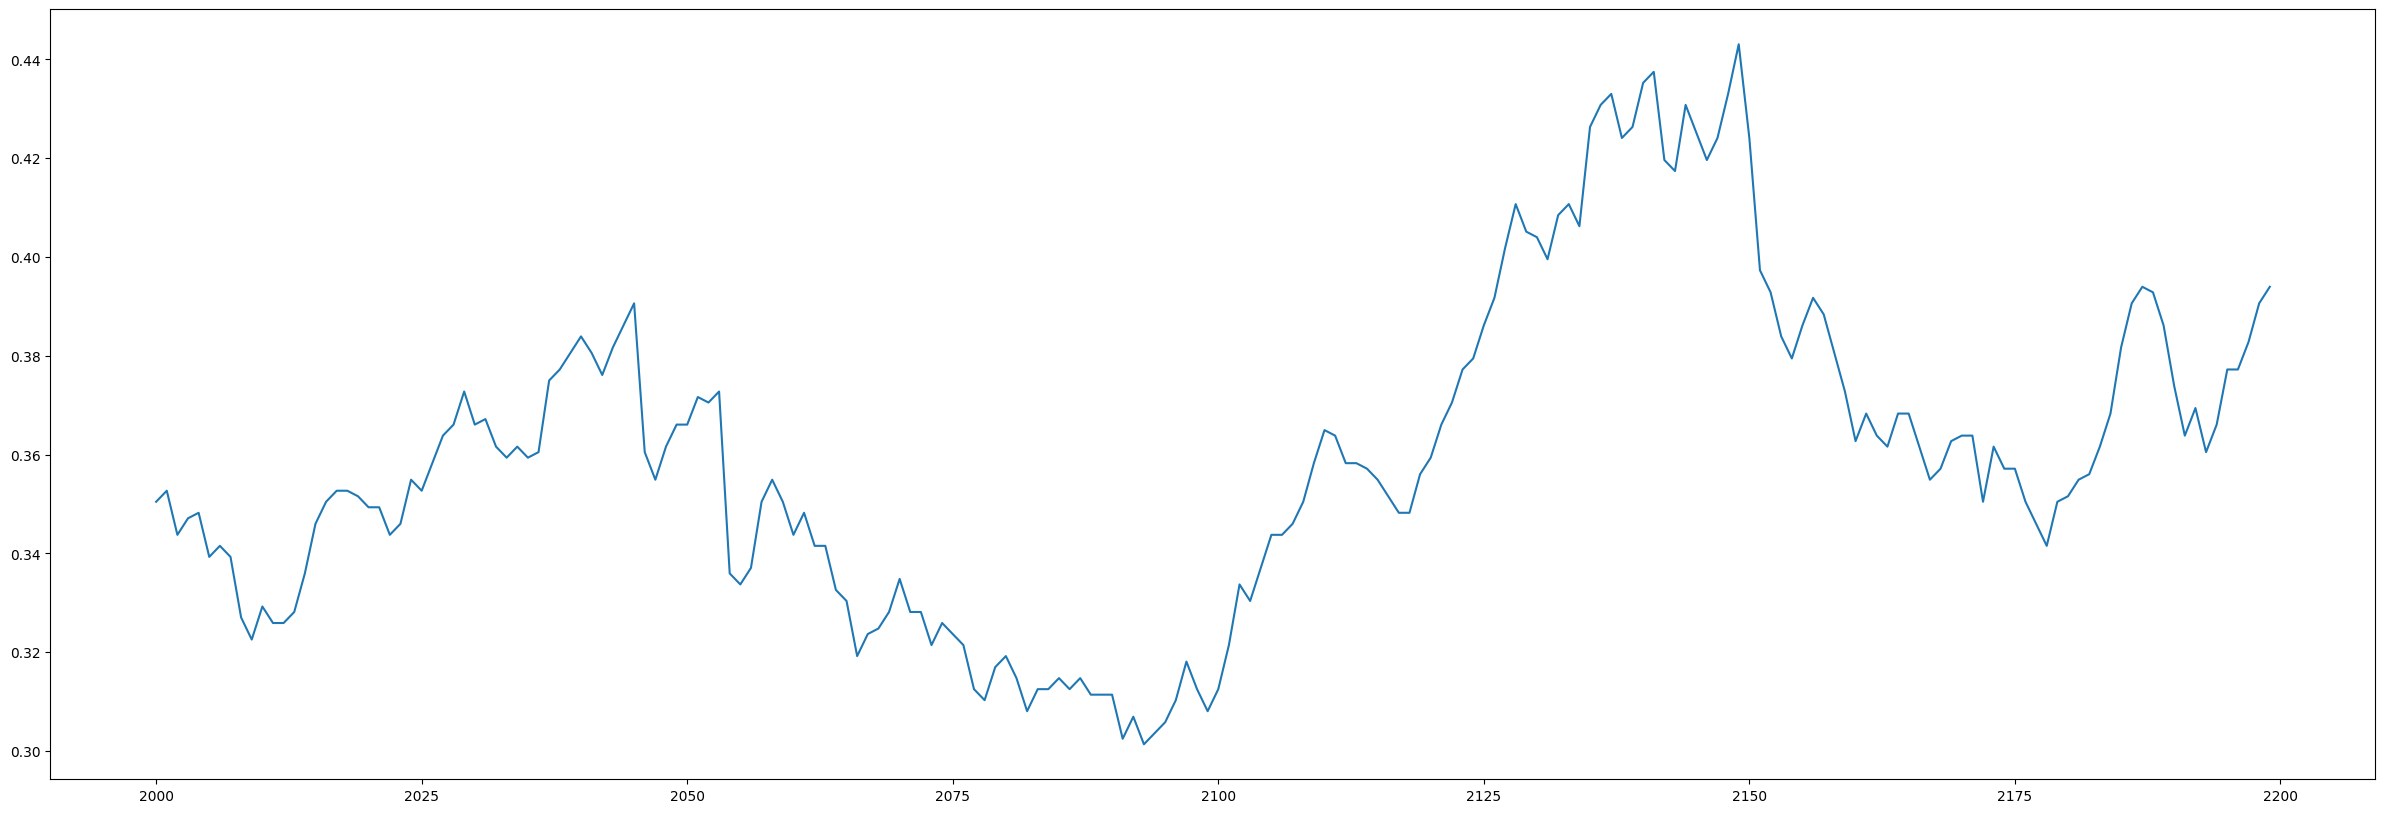

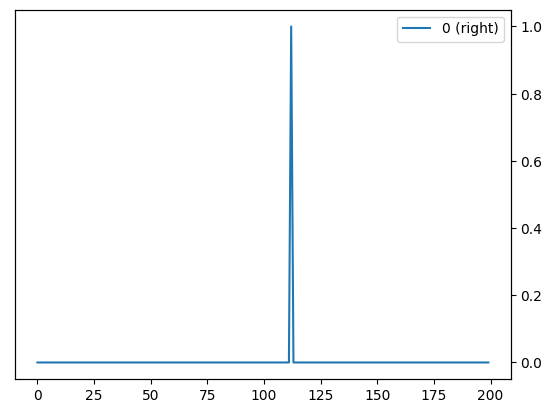

In [67]:
data["close"][2000:2200].plot(figsize=(30, 10))
(pd.DataFrame(np.where(data["pinbar_sell"][2000:2200], 1, 0))).plot(secondary_y=True)

In [55]:
data["%-pullback"] = detect_pullback(data)
data

,date,open,high,low,close,adj_close,volume,smi,hl2,fisher_cg,fisher_sig,hurst,%-hurst,pb_pct_change,pb_zscore,pullback_flag,%-pullback
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600,NaN,0.128627,NaN,NaN,0.830706,0.830706,NaN,NaN,0,0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800,NaN,0.121931,NaN,NaN,0.830706,0.830706,-0.052171,NaN,0,0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000,NaN,0.113002,NaN,NaN,0.830706,0.830706,-0.073398,NaN,0,0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600,NaN,0.115792,NaN,NaN,0.830706,0.830706,0.024751,NaN,0,0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600,NaN,0.119141,NaN,NaN,0.830706,0.830706,0.028992,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,58.317374,181.494995,-0.314425,-0.578232,0.573979,0.573979,-0.007571,-0.839777,0,0
10709,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,44.412485,178.774994,-0.062151,-0.314425,0.547303,0.547303,-0.002060,-0.386143,0,0
10710,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,27.863297,179.265007,0.176785,-0.062151,0.542598,0.542598,-0.007756,-0.850026,0,0
10711,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,23.493459,179.150002,0.407077,0.176785,0.512509,0.512509,0.015465,0.959315,0,0


<AxesSubplot: >

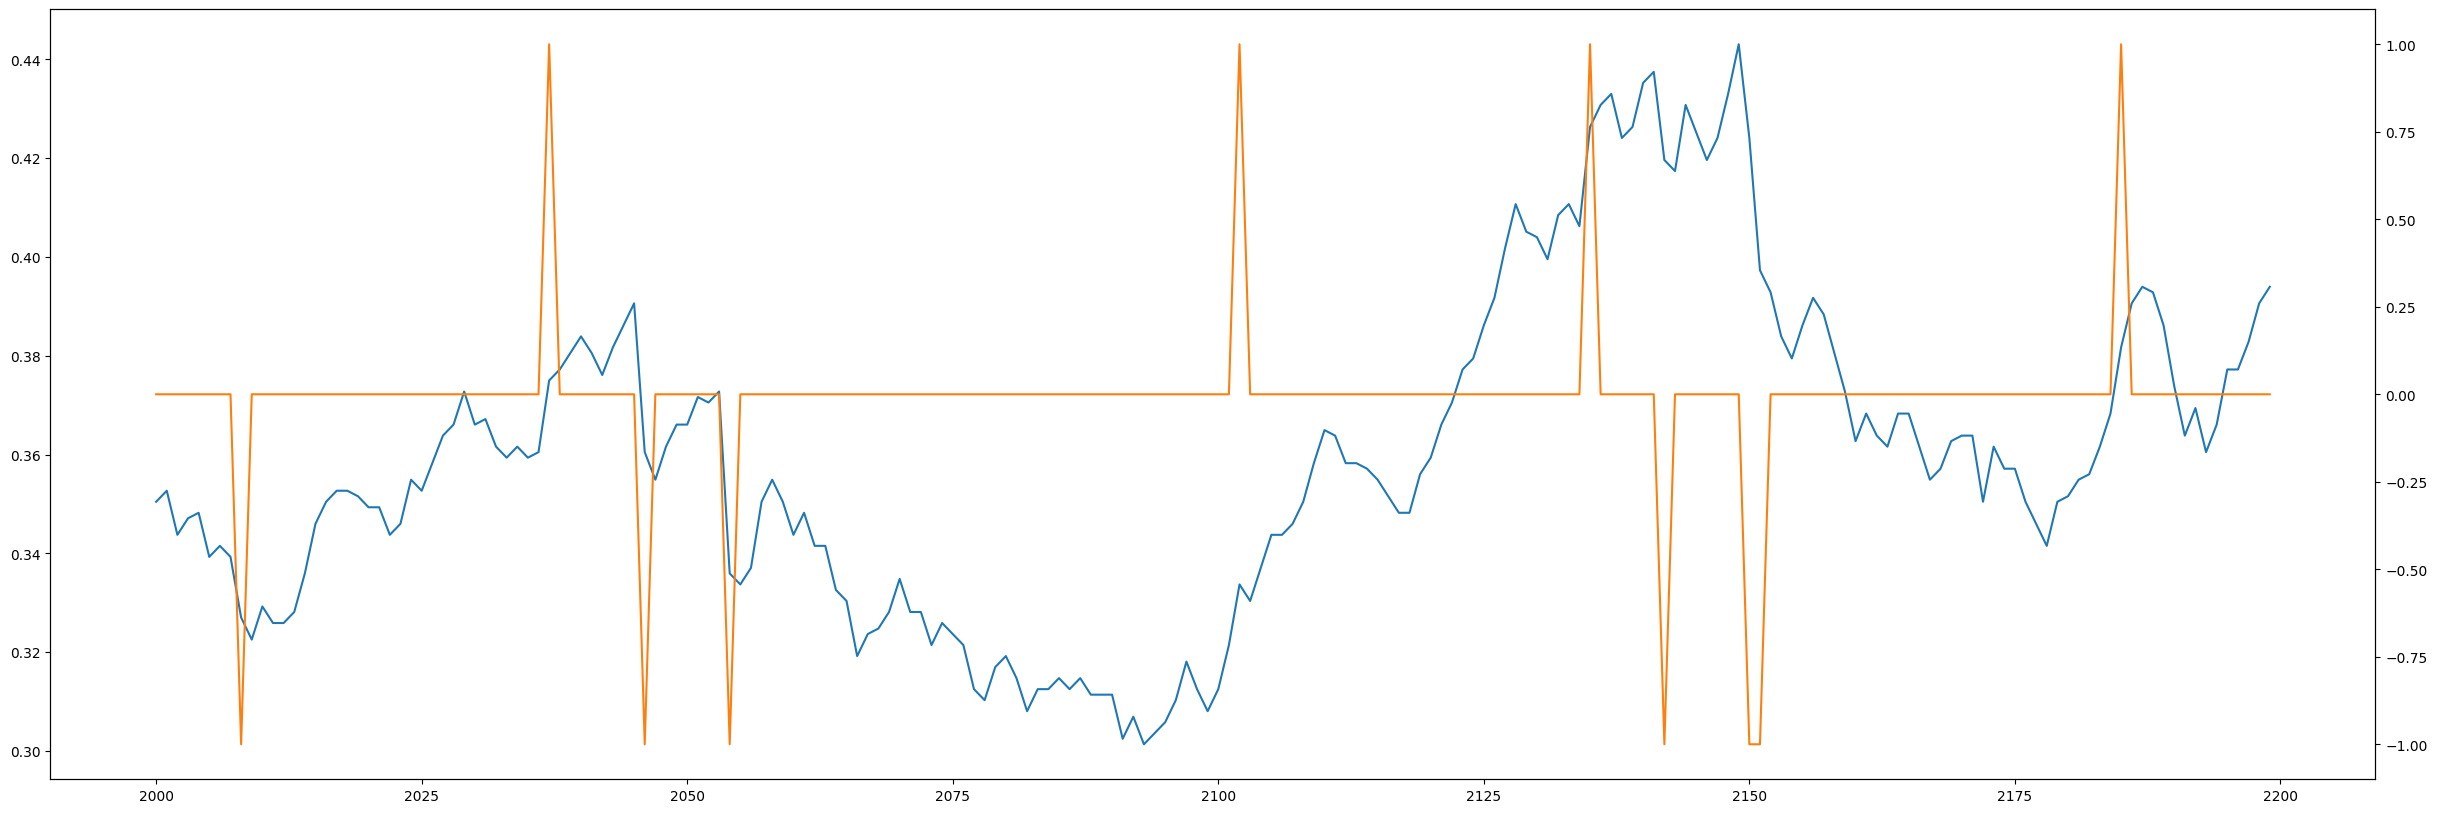

In [56]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["%-pullback"][2000:2200]).plot(secondary_y=True)

In [57]:
dynamic_exhaustion_bars(data)

,date,open,high,low,close,adj_close,volume,smi,hl2,fisher_cg,...,%-pullback,close_pct_change,pct_change_zscore,pct_change_zscore_smoothed,maj_qual,min_qual,maj_len,min_len,leledc_major,leledc_minor
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600,NaN,0.128627,NaN,...,0,NaN,NaN,1.000000,0.0,0.0,7,7,NaN,0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800,NaN,0.121931,NaN,...,0,-0.052171,NaN,1.000000,9.0,9.0,7,7,NaN,0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000,NaN,0.113002,NaN,...,0,-0.073398,NaN,1.000000,9.0,9.0,7,7,NaN,0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600,NaN,0.115792,NaN,...,0,0.024751,NaN,1.000000,9.0,9.0,7,7,NaN,0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600,NaN,0.119141,NaN,...,0,0.028992,NaN,1.000000,9.0,9.0,7,7,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,58.317374,181.494995,-0.314425,...,0,-0.007571,-1.100109,-0.050580,15.0,15.0,7,7,1.0,0
10709,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,44.412485,178.774994,-0.062151,...,0,-0.002060,-0.437478,-0.504446,15.0,15.0,7,7,1.0,0
10710,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,27.863297,179.265007,0.176785,...,0,-0.007756,-1.140967,-0.892851,15.0,15.0,7,7,1.0,0
10711,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,23.493459,179.150002,0.407077,...,0,0.015465,1.547542,-0.010301,15.0,15.0,7,7,1.0,0


<AxesSubplot: >

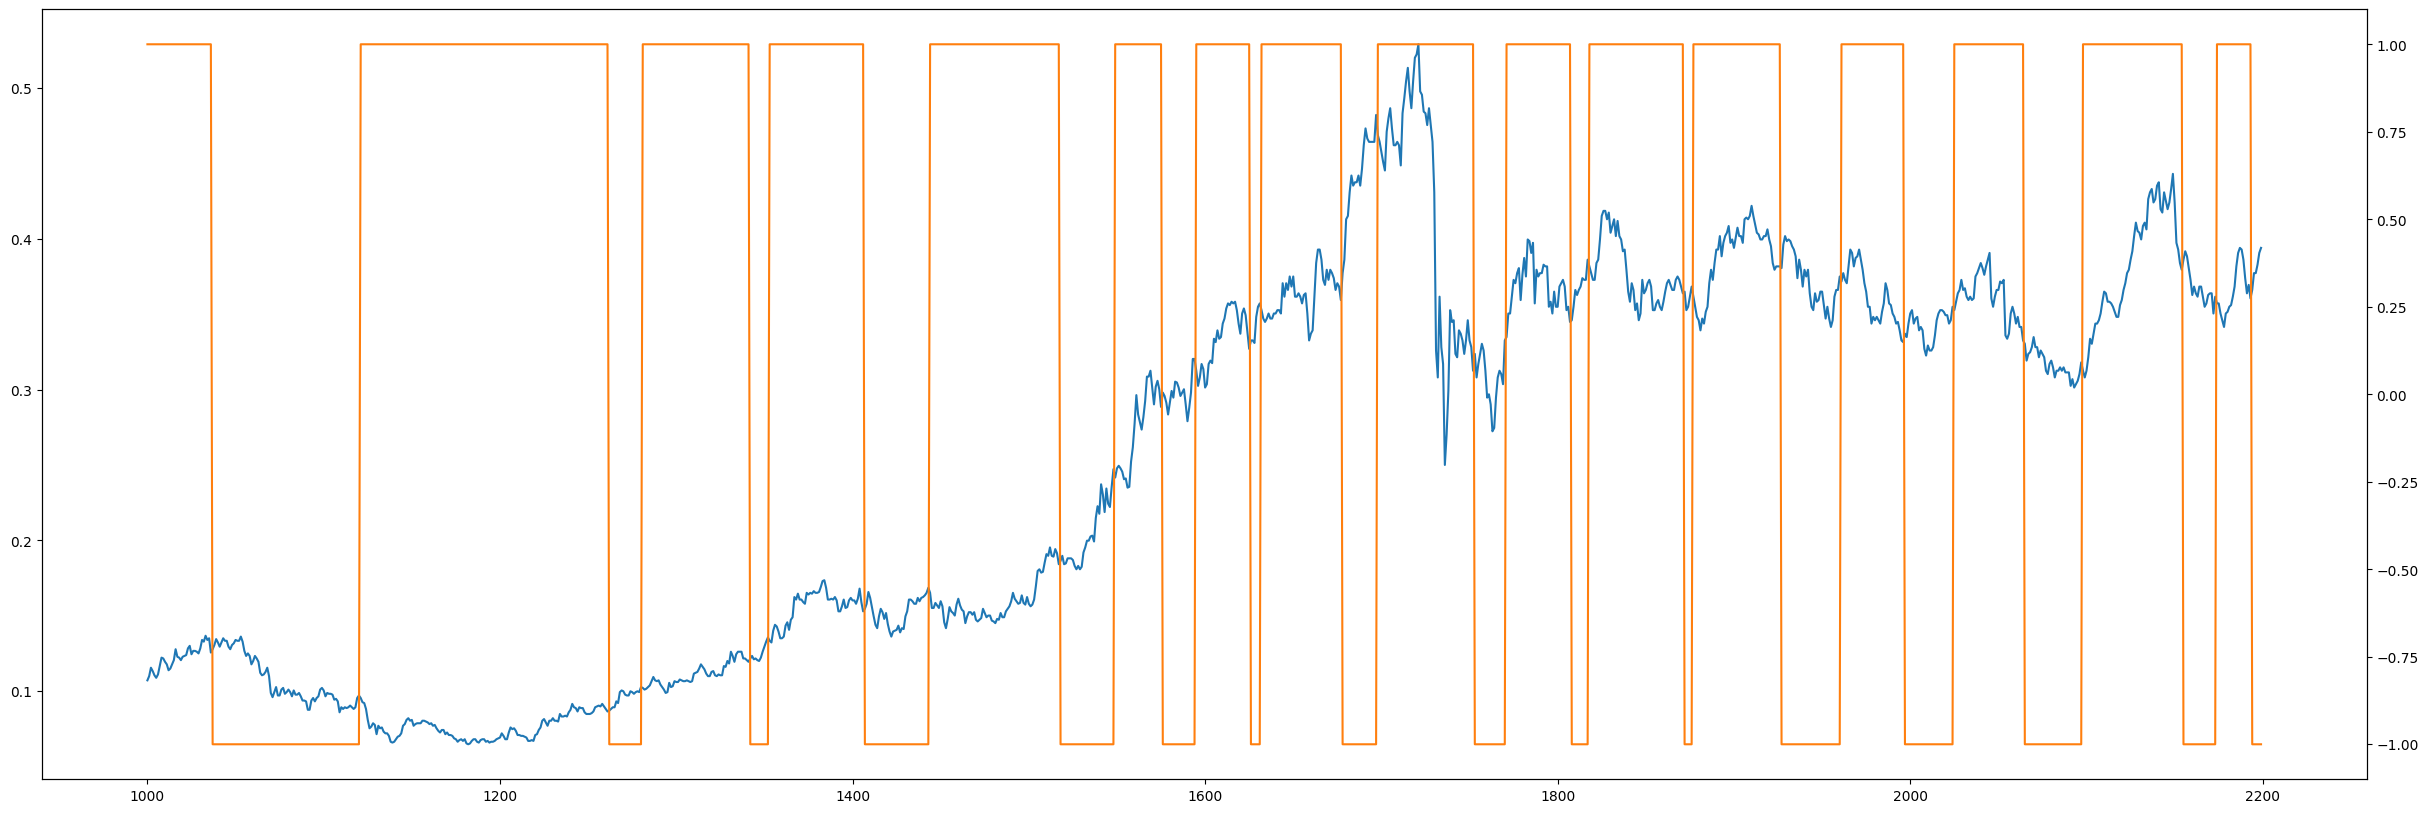

In [68]:
data["close"][1000:2200].plot(figsize=(30, 10))
(data["leledc_major"][1000:2200]).plot(secondary_y=True)

<AxesSubplot: >

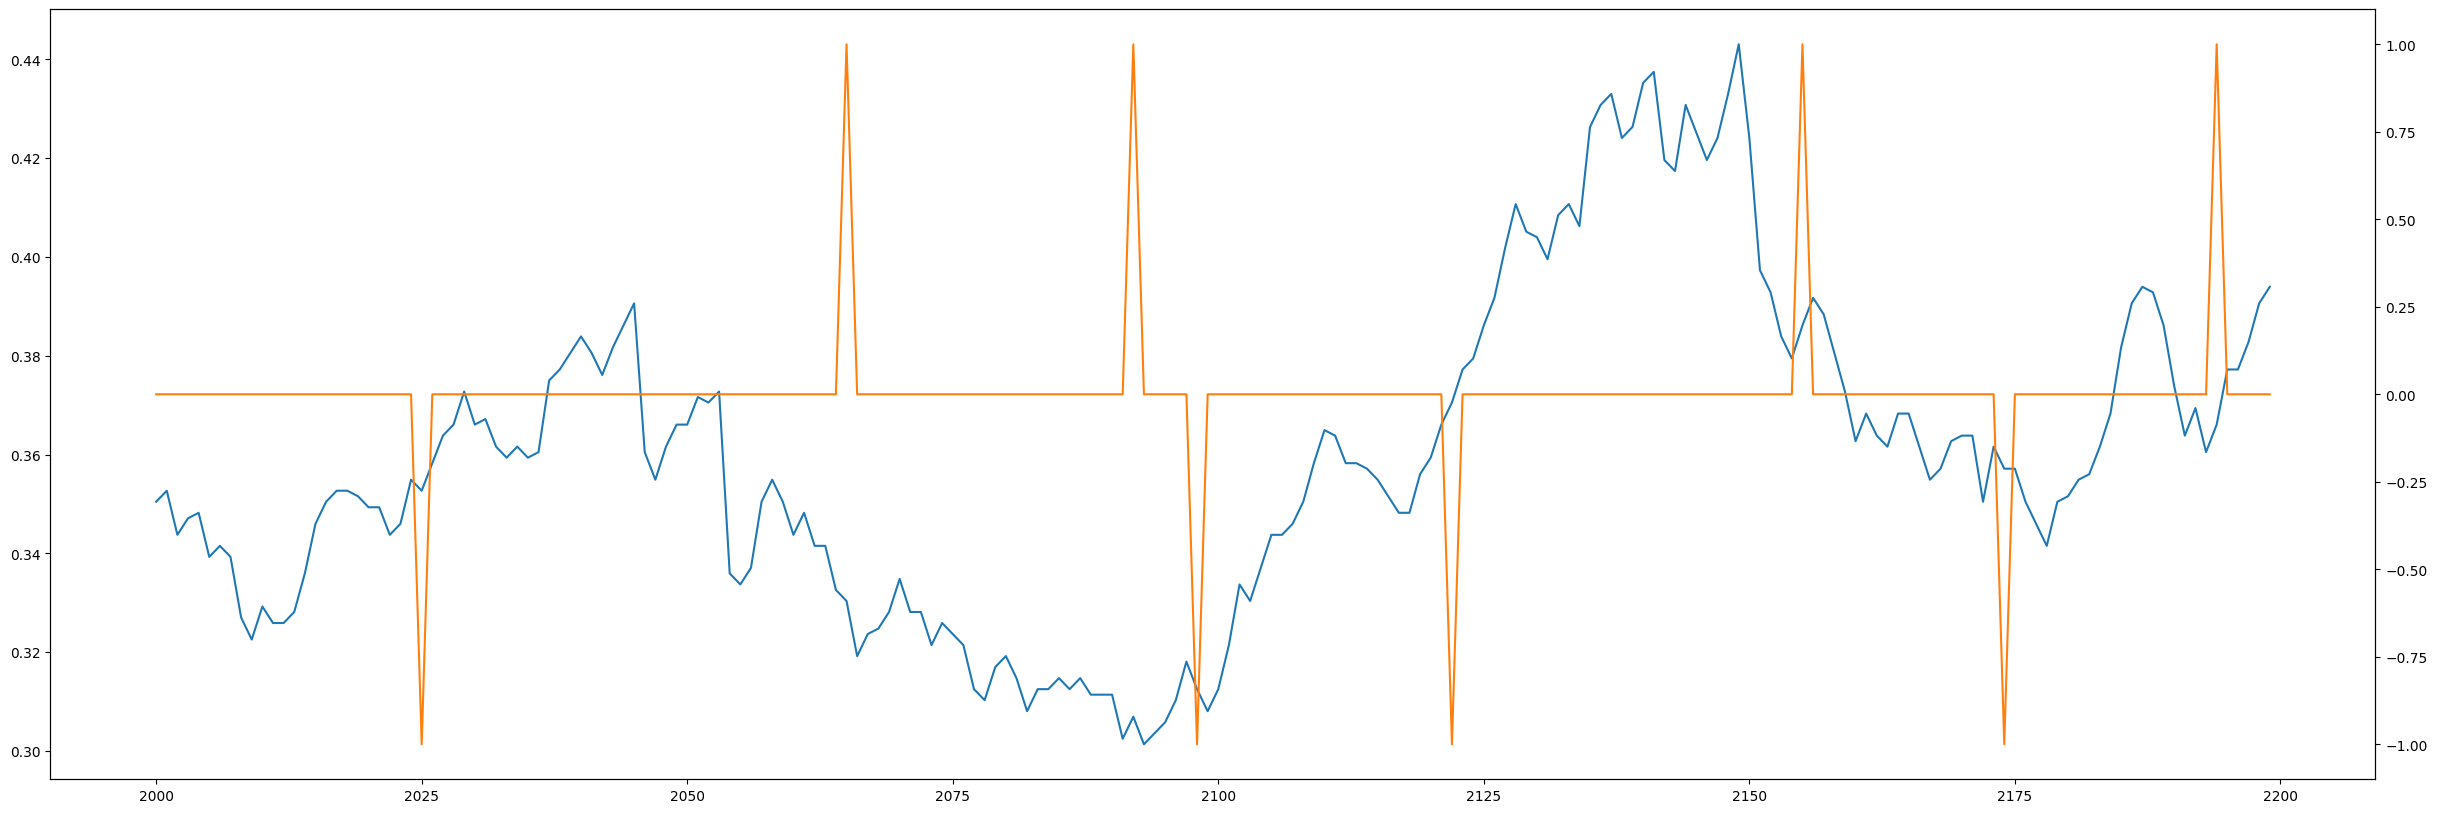

In [59]:
data["close"][2000:2200].plot(figsize=(30, 10))
(data["leledc_minor"][2000:2200]).plot(secondary_y=True)

<AxesSubplot: >

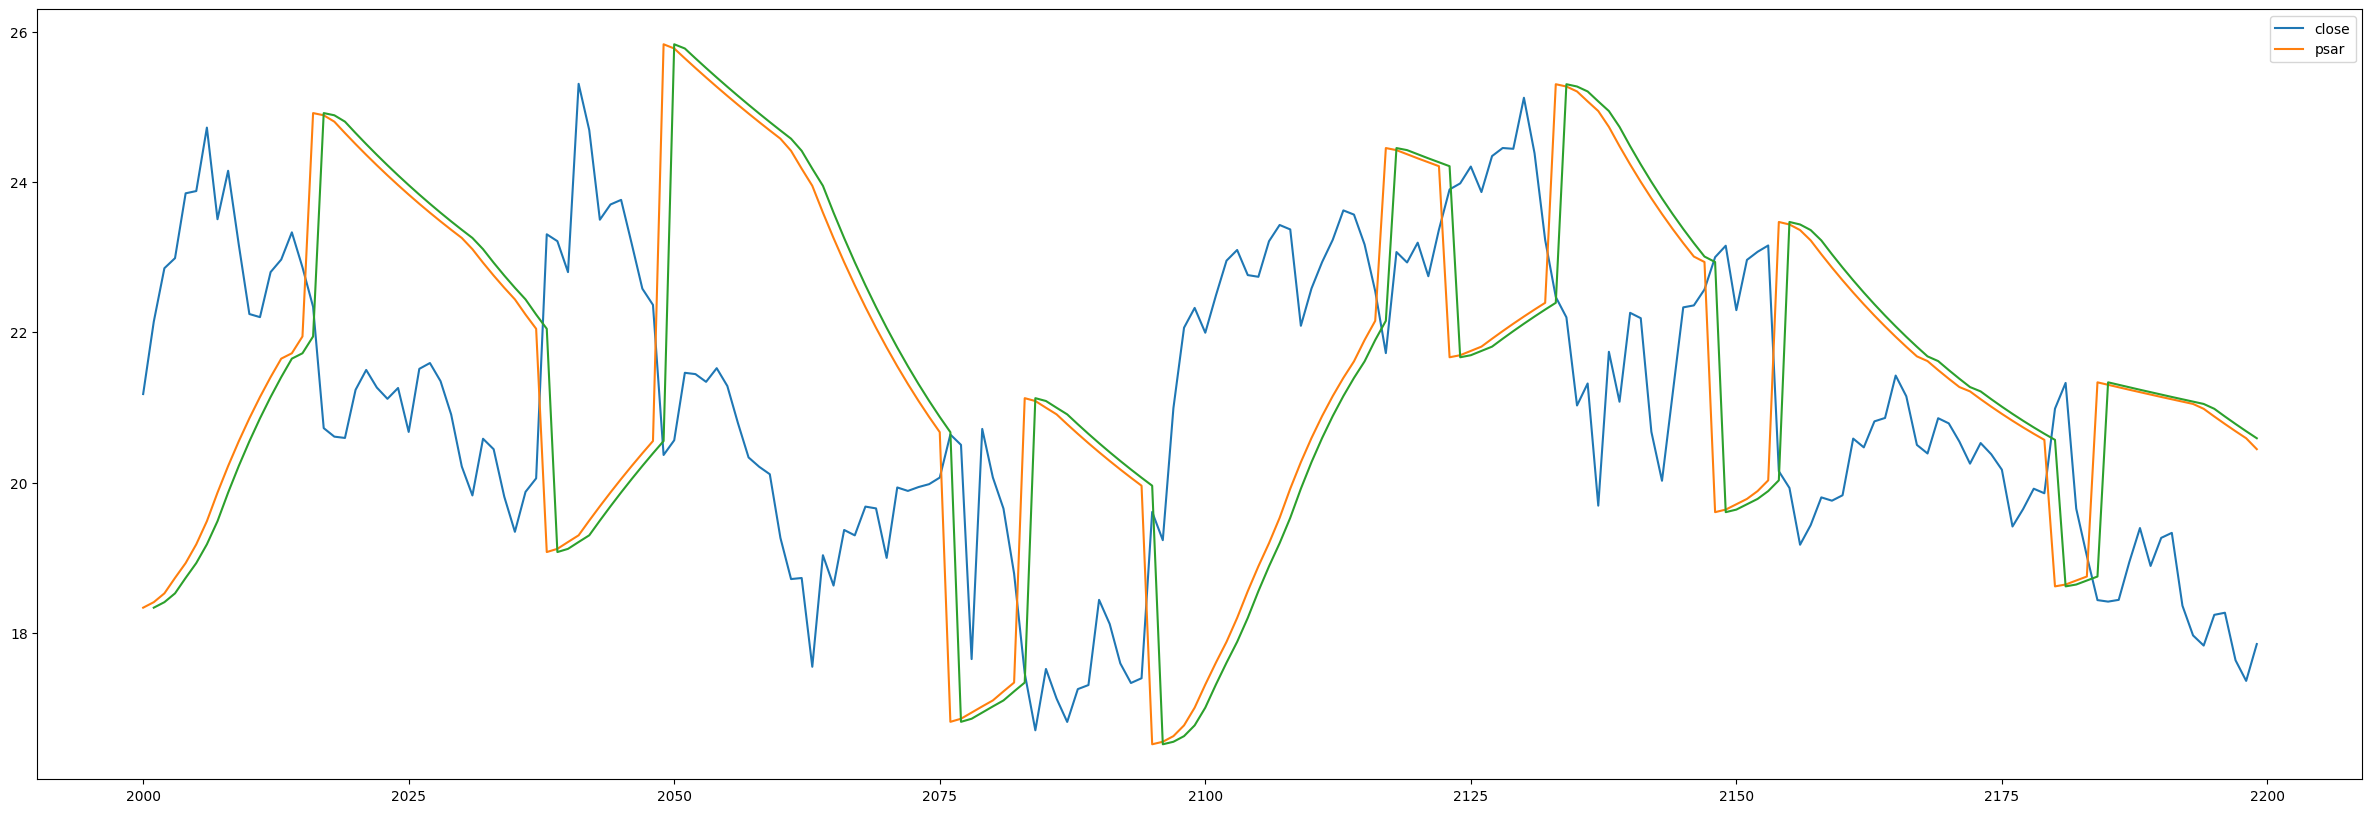

In [19]:
data["psar"] = ta.SAR(data["high"], data["low"], acceleration=0.01, maximum=0.2)
data[["close", "psar"]][2000:2200].plot(figsize=(30, 10))
(data["psar"][2000:2200].shift(1)).plot()

In [8]:
data["psar_buy"] = qtpylib.crossed_above(data["psar"], data["psar"].shift(1))
data["psar_sell"] = qtpylib.crossed_below(data["psar"], data["psar"].shift(1))

In [9]:
data["psar"] > data["psar"].shift(1)

0       False
1       False
2        True
3        True
4        True
        ...  
3235    False
3236    False
3237    False
3238    False
3239    False
Name: psar, Length: 3240, dtype: bool

In [11]:
data["APO"] = ta.APO(data["close"], fastperiod=12, slowperiod=26, matype=0)

<AxesSubplot: >

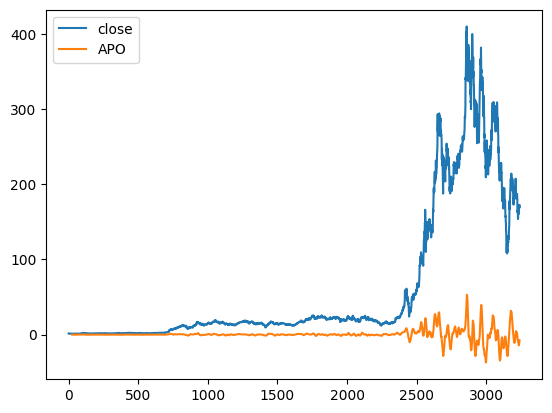

In [12]:
data[["close", "APO"]].plot()

In [ ]:
macd, macdsignal, macdhist = ta.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

In [ ]:
data["macd"] = macd
data["macdsignal"] = macdsignal
data["macdhist"] = macdhist

In [ ]:
data[["Close", "macd", "macdsignal", "macdhist"]].plot()

In [ ]:
data["PPO"] = ta.PPO(data["close"], fastperiod=12, slowperiod=26, matype=0)

In [ ]:
data[["close", "PPO"]].plot()

In [ ]:
(-1 + data["PPO"]).cumprod()

In [ ]:
data["PPO"]-1

In [21]:
import sklearn.metrics as m
m.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_